In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import random

from _price_optimization import get_ideals
from _simulations import simulate_regrets
from _plot import regrets_plot

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Data Preparation

In [5]:
df = pd.read_csv("auction97.csv")
df.head()

/var/folders/yh/wjjhzwhx54b5t1_q6yd628240000gn/T/ipykernel_88632/3462240926.py:1: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("auction97.csv")


,Unnamed: 0,auction_id,auction_description,round,item_name,item_description,bidder_name,bidder_frn,market,block,...,solver_optimum_percentage,solver_options,price_weight,previous_pw_bidder,previous_pw_bidder_frn,round_of_previous_pwb,round_of_withdrawal,round_withdrawn_pwb_placed,withdrawn_pwb_amount,withdrawn_net_pwb_amount
0,0,97,AWS-3,1.0,AW-BEA001-H,Bangor ME,T-Mobile License LLC,1565449.0,BEA001,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,97,AWS-3,1.0,AW-BEA002-H,Portland ME,T-Mobile License LLC,1565449.0,BEA002,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,97,AWS-3,1.0,AW-BEA002-J,Portland ME,AT&T Wireless Services 3 LLC,23910920.0,BEA002,J,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,97,AWS-3,1.0,AW-BEA003-B1,Boston-Worcester MA-NH-RI-VT,2014 AWS Spectrum Bidco Corporation,23933575.0,BEA003,B1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,97,AWS-3,1.0,AW-BEA003-H,Boston-Worcester MA-NH-RI-VT,"Northstar Wireless, LLC",23917453.0,BEA003,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
useful_df = df[["round", "item_name", "block", "bidder_name", "bid_amount"]].dropna()
useful_df.head()

,round,item_name,block,bidder_name,bid_amount
0,1.0,AW-BEA001-H,H,T-Mobile License LLC,43000.0
1,1.0,AW-BEA002-H,H,T-Mobile License LLC,387000.0
2,1.0,AW-BEA002-J,J,AT&T Wireless Services 3 LLC,775000.0
3,1.0,AW-BEA003-B1,B1,2014 AWS Spectrum Bidco Corporation,4539000.0
4,1.0,AW-BEA003-H,H,"Northstar Wireless, LLC",13616000.0


In [7]:
clean_df = (
    useful_df.sort_values("round", ascending=False)
    .groupby(["item_name", "bidder_name"])
    .first()
    .reset_index()
)
clean_df.head()

,item_name,bidder_name,round,block,bid_amount
0,AW-BEA001-A1,American AWS-3 Wireless I L.L.C.,19.0,A1,9800.0
1,AW-BEA001-A1,"Northstar Wireless, LLC",255.0,A1,36000.0
2,AW-BEA001-A1,"SNR Wireless LicenseCo, LLC",255.0,A1,36000.0
3,AW-BEA001-A1,"Sofio, Joseph A",254.0,A1,31000.0
4,AW-BEA001-B1,2014 AWS Spectrum Bidco Corporation,39.0,B1,71000.0


In [8]:
clean_df.groupby("block")["bid_amount"].count()

block
A1     679
B1     846
G     4286
H     1126
I     1037
J      923
Name: bid_amount, dtype: int64

In [9]:
data = clean_df[["block", "bidder_name", "bid_amount"]].groupby("block")

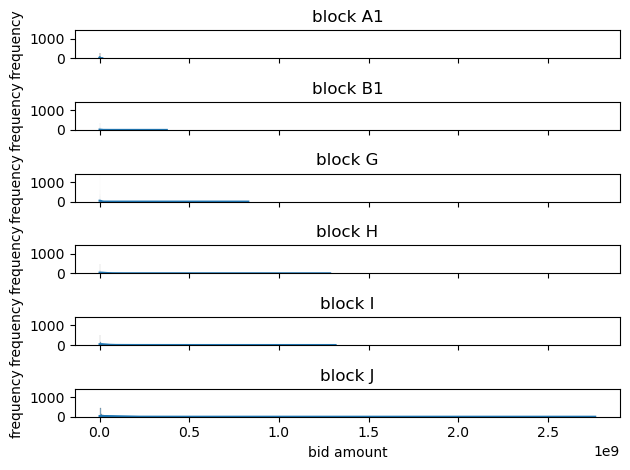

In [10]:
# Set up subplots
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True)

# Plot each group in a separate subplot
for (block, group), ax in zip(data, axes):
    sns.histplot(group["bid_amount"], kde=True, ax=ax)
    ax.set_title(f"block {block}")
    ax.set_xlabel("bid amount")
    ax.set_ylabel("frequency")

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [11]:
clean_df["log_bid"] = clean_df["bid_amount"].transform(np.log)
log_data = clean_df[["block", "bidder_name", "log_bid"]].groupby("block")

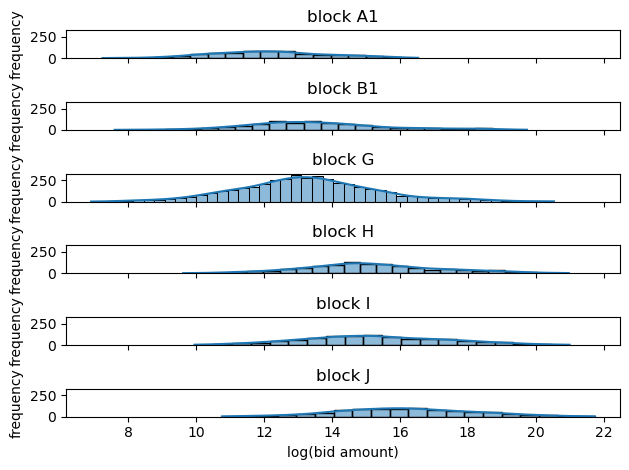

In [12]:
# Set up subplots
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True)

# Plot each group in a separate subplot
for (block, group), ax in zip(log_data, axes):
    sns.histplot(group["log_bid"], kde=True, ax=ax)
    ax.set_title(f"block {block}")
    ax.set_xlabel("log(bid amount)")
    ax.set_ylabel("frequency")

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

In [13]:
log_data["log_bid"].agg(["min", "max"]).reset_index()
# Set lower = 7 and upper = 20

,block,min,max
0,A1,7.244228,16.539959
1,B1,7.600902,19.742199
2,G,6.907755,20.535932
3,H,9.615805,20.974340
4,I,9.952278,20.997635
5,J,10.757903,21.739570


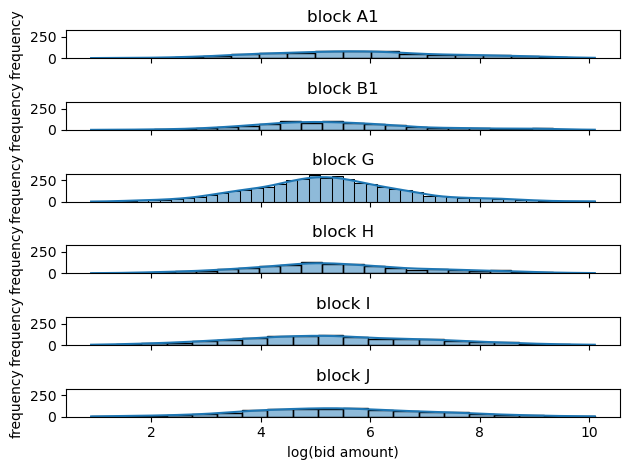

In [14]:
# Define the target range
target_min, target_max = 0.9, 10.1

# Apply full-range scaling to each group
clean_df["scaled_log_bid"] = clean_df.groupby("block")["log_bid"].transform(
    lambda x: target_min
    + ((x - x.min()) / (x.max() - x.min())) * (target_max - target_min)
)
scaled_log_data = clean_df[["block", "bidder_name", "scaled_log_bid"]].groupby("block")

# Set up subplots
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True)

# Plot each group in a separate subplot
for (block, group), ax in zip(scaled_log_data, axes):
    sns.histplot(group["scaled_log_bid"], kde=True, ax=ax)
    ax.set_title(f"block {block}")
    ax.set_xlabel("log(bid amount)")
    ax.set_ylabel("frequency")

# Adjust layout for a clean look
plt.tight_layout()
plt.show()

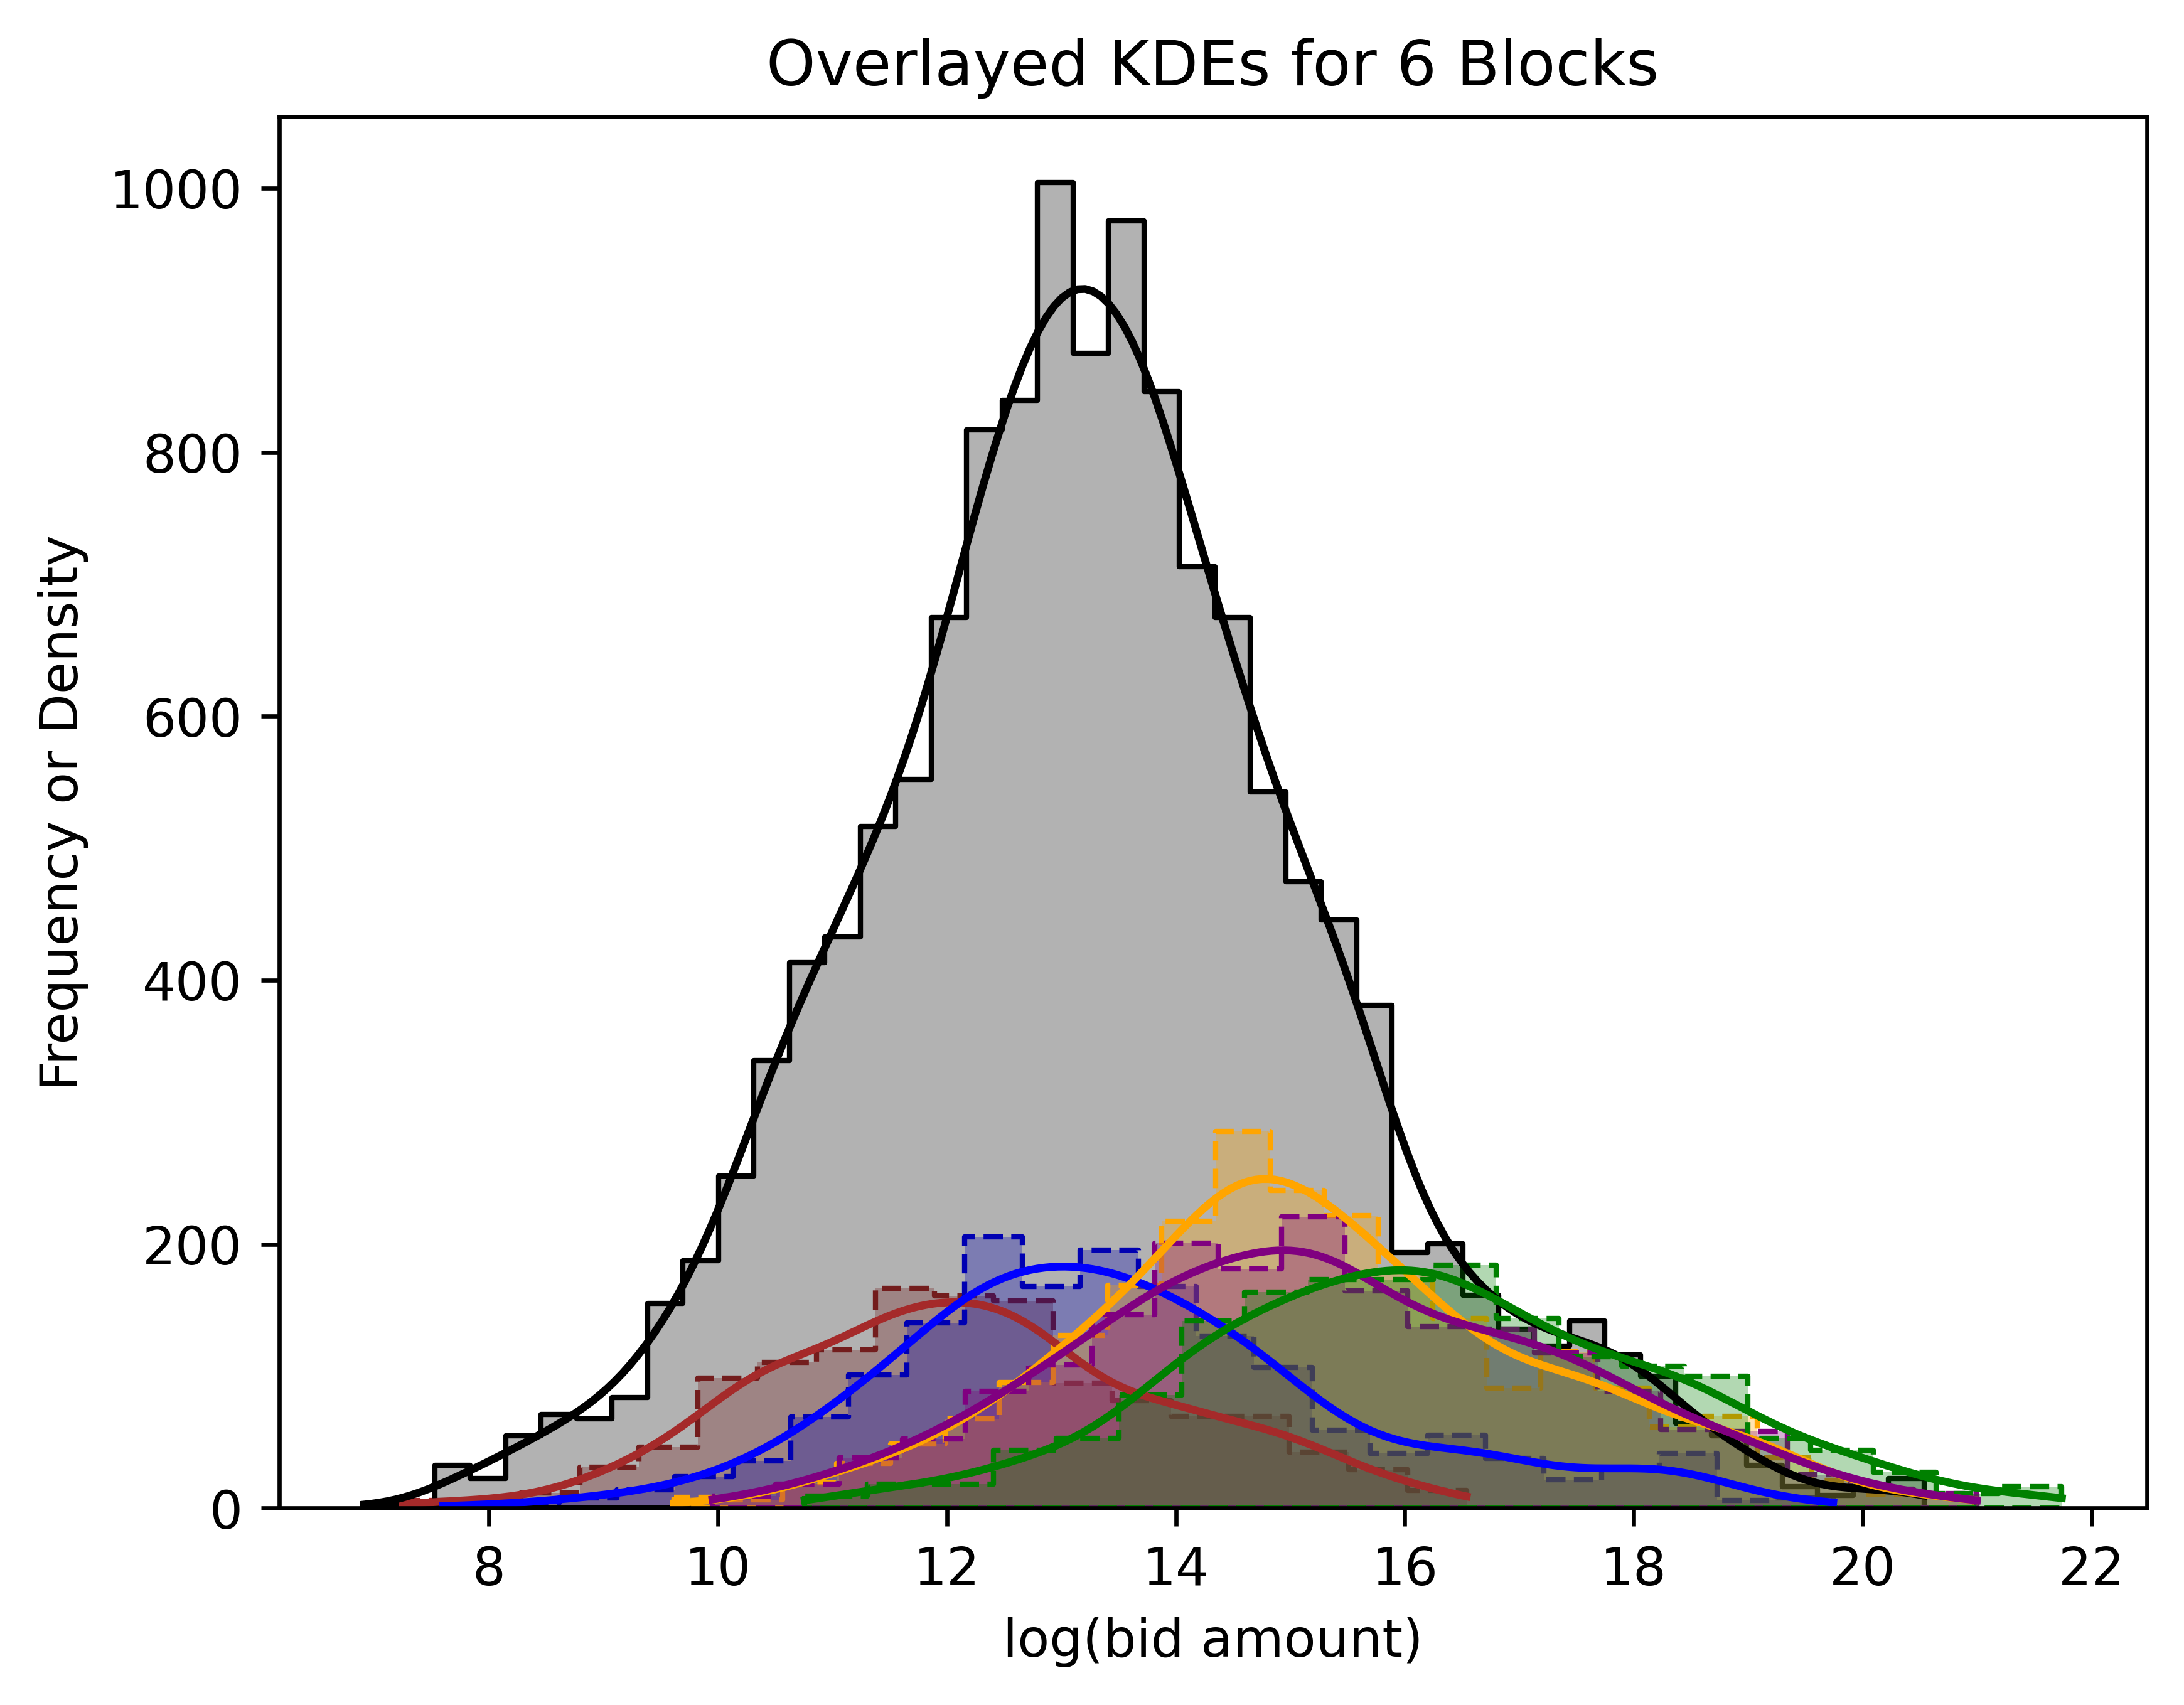

In [18]:
plt.figure(dpi=600)
colors = [
    "brown",
    "blue",
    "orange",
    "purple",
    "green",
]

i = 0
for (block, group), ax in zip(log_data, axes):
    if block == "G":
        sns.histplot(
            group["log_bid"],
            kde=True,
            label=block,
            stat="frequency",
            element="step",
            alpha=0.3,
            color="black",
        )
    else:
        sns.histplot(
            group["log_bid"],
            kde=True,
            label=block,
            stat="frequency",
            element="step",
            alpha=0.3,
            color=colors[i],
            linestyle="--",
        )
        i += 1


plt.xlabel("log(bid amount)")
plt.ylabel("Frequency or Density")
plt.title("Overlayed KDEs for 6 Blocks")
plt.show()

# Generate Training and Test Data

In [ ]:
# First, construct the distributions
dict_true_cdfs = {}
# Use the KDE CDF to mimic the true CDF
for block, group in scaled_log_data:

    # Step 1: Fit a KDE to the data
    kde = gaussian_kde(group["scaled_log_bid"])

    # Step 2: Define an x-axis range over which to evaluate the PDF and CDF
    x_values = np.linspace(1, 10, 1024)

    # Step 3: Evaluate the PDF
    pdf_values = kde(x_values)

    # Step 4: Compute the CDF by cumulative integration of the PDF
    cdf_values = cumtrapz(pdf_values, x_values, initial=0)  # `initial=0` to start at 0

    # Step 5: Create an interpolated function for the CDF
    cdf_function = interp1d(x_values, cdf_values, bounds_error=False, fill_value=(0, 1))

    dict_true_cdfs[block] = cdf_function

In [ ]:
scaled_log_data["scaled_log_bid"].count()

block
A1     679
B1     846
G     4286
H     1126
I     1037
J      923
Name: scaled_log_bid, dtype: int64

In [ ]:
# Set the seed
random.seed(42)
np.random.seed(63)

In [ ]:
# Pick G (the distribution with the most samples as the test distribution)
test_data = np.array(
    [
        scaled_log_data.get_group("G")["scaled_log_bid"].sample(200, replace=True)
        for _ in range(1000)
    ]
)

In [ ]:
train_blocks = list(scaled_log_data.groups.keys())
train_blocks.remove("G")
train_dists = random.choices(train_blocks, k=200)
train_data = np.array(
    [
        scaled_log_data.get_group(train_dists[i])["scaled_log_bid"].sample(
            200, replace=True
        )
        for i in range(200)
    ]
)

In [ ]:
# Construct the bids dictionary
bids_dict = {
    "dist_name": "real",
    "true_cdfs": [dict_true_cdfs["G"] for _ in range(1000)],
    "bids": test_data,
    "train_bids": train_data,
}
bids_dict["ideals"] = get_ideals(
    bids_dict["dist_name"], lower=1, upper=10, true_cdfs=bids_dict["true_cdfs"]
)

/Users/qiqi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


# Regrets Calculation

In [2]:
ns = [10, 20, 50, 200]
Nn_trains = [(50, 10), (50, 200), (200, 200)]

In [ ]:
regrets_to_plot = []
for n in ns:
    regrets_to_plot.append(simulate_regrets(bids_dict, 1, 10, "ecdf", N=1000, n=n))
    regrets_to_plot.append(simulate_regrets(bids_dict, 1, 10, "kde", N=1000, n=n))
    for N_train, n_train in Nn_trains:
        regrets_to_plot.append(
            simulate_regrets(
                bids_dict,
                1,
                10,
                "rde",
                N=1000,
                n=n,
                N_train=N_train,
                n_train=n_train,
            )
        )

In [ ]:
import pickle

# Write object to a file
with open("real_regrets.pkl", "wb") as file:
    pickle.dump(regrets_to_plot, file)

In [3]:
import pickle

# Read object back from the file
with open("real_regrets.pkl", "rb") as file:
    regrets_to_plot = pickle.load(file)

/Users/qiqi/Desktop/ADPP/_plot.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


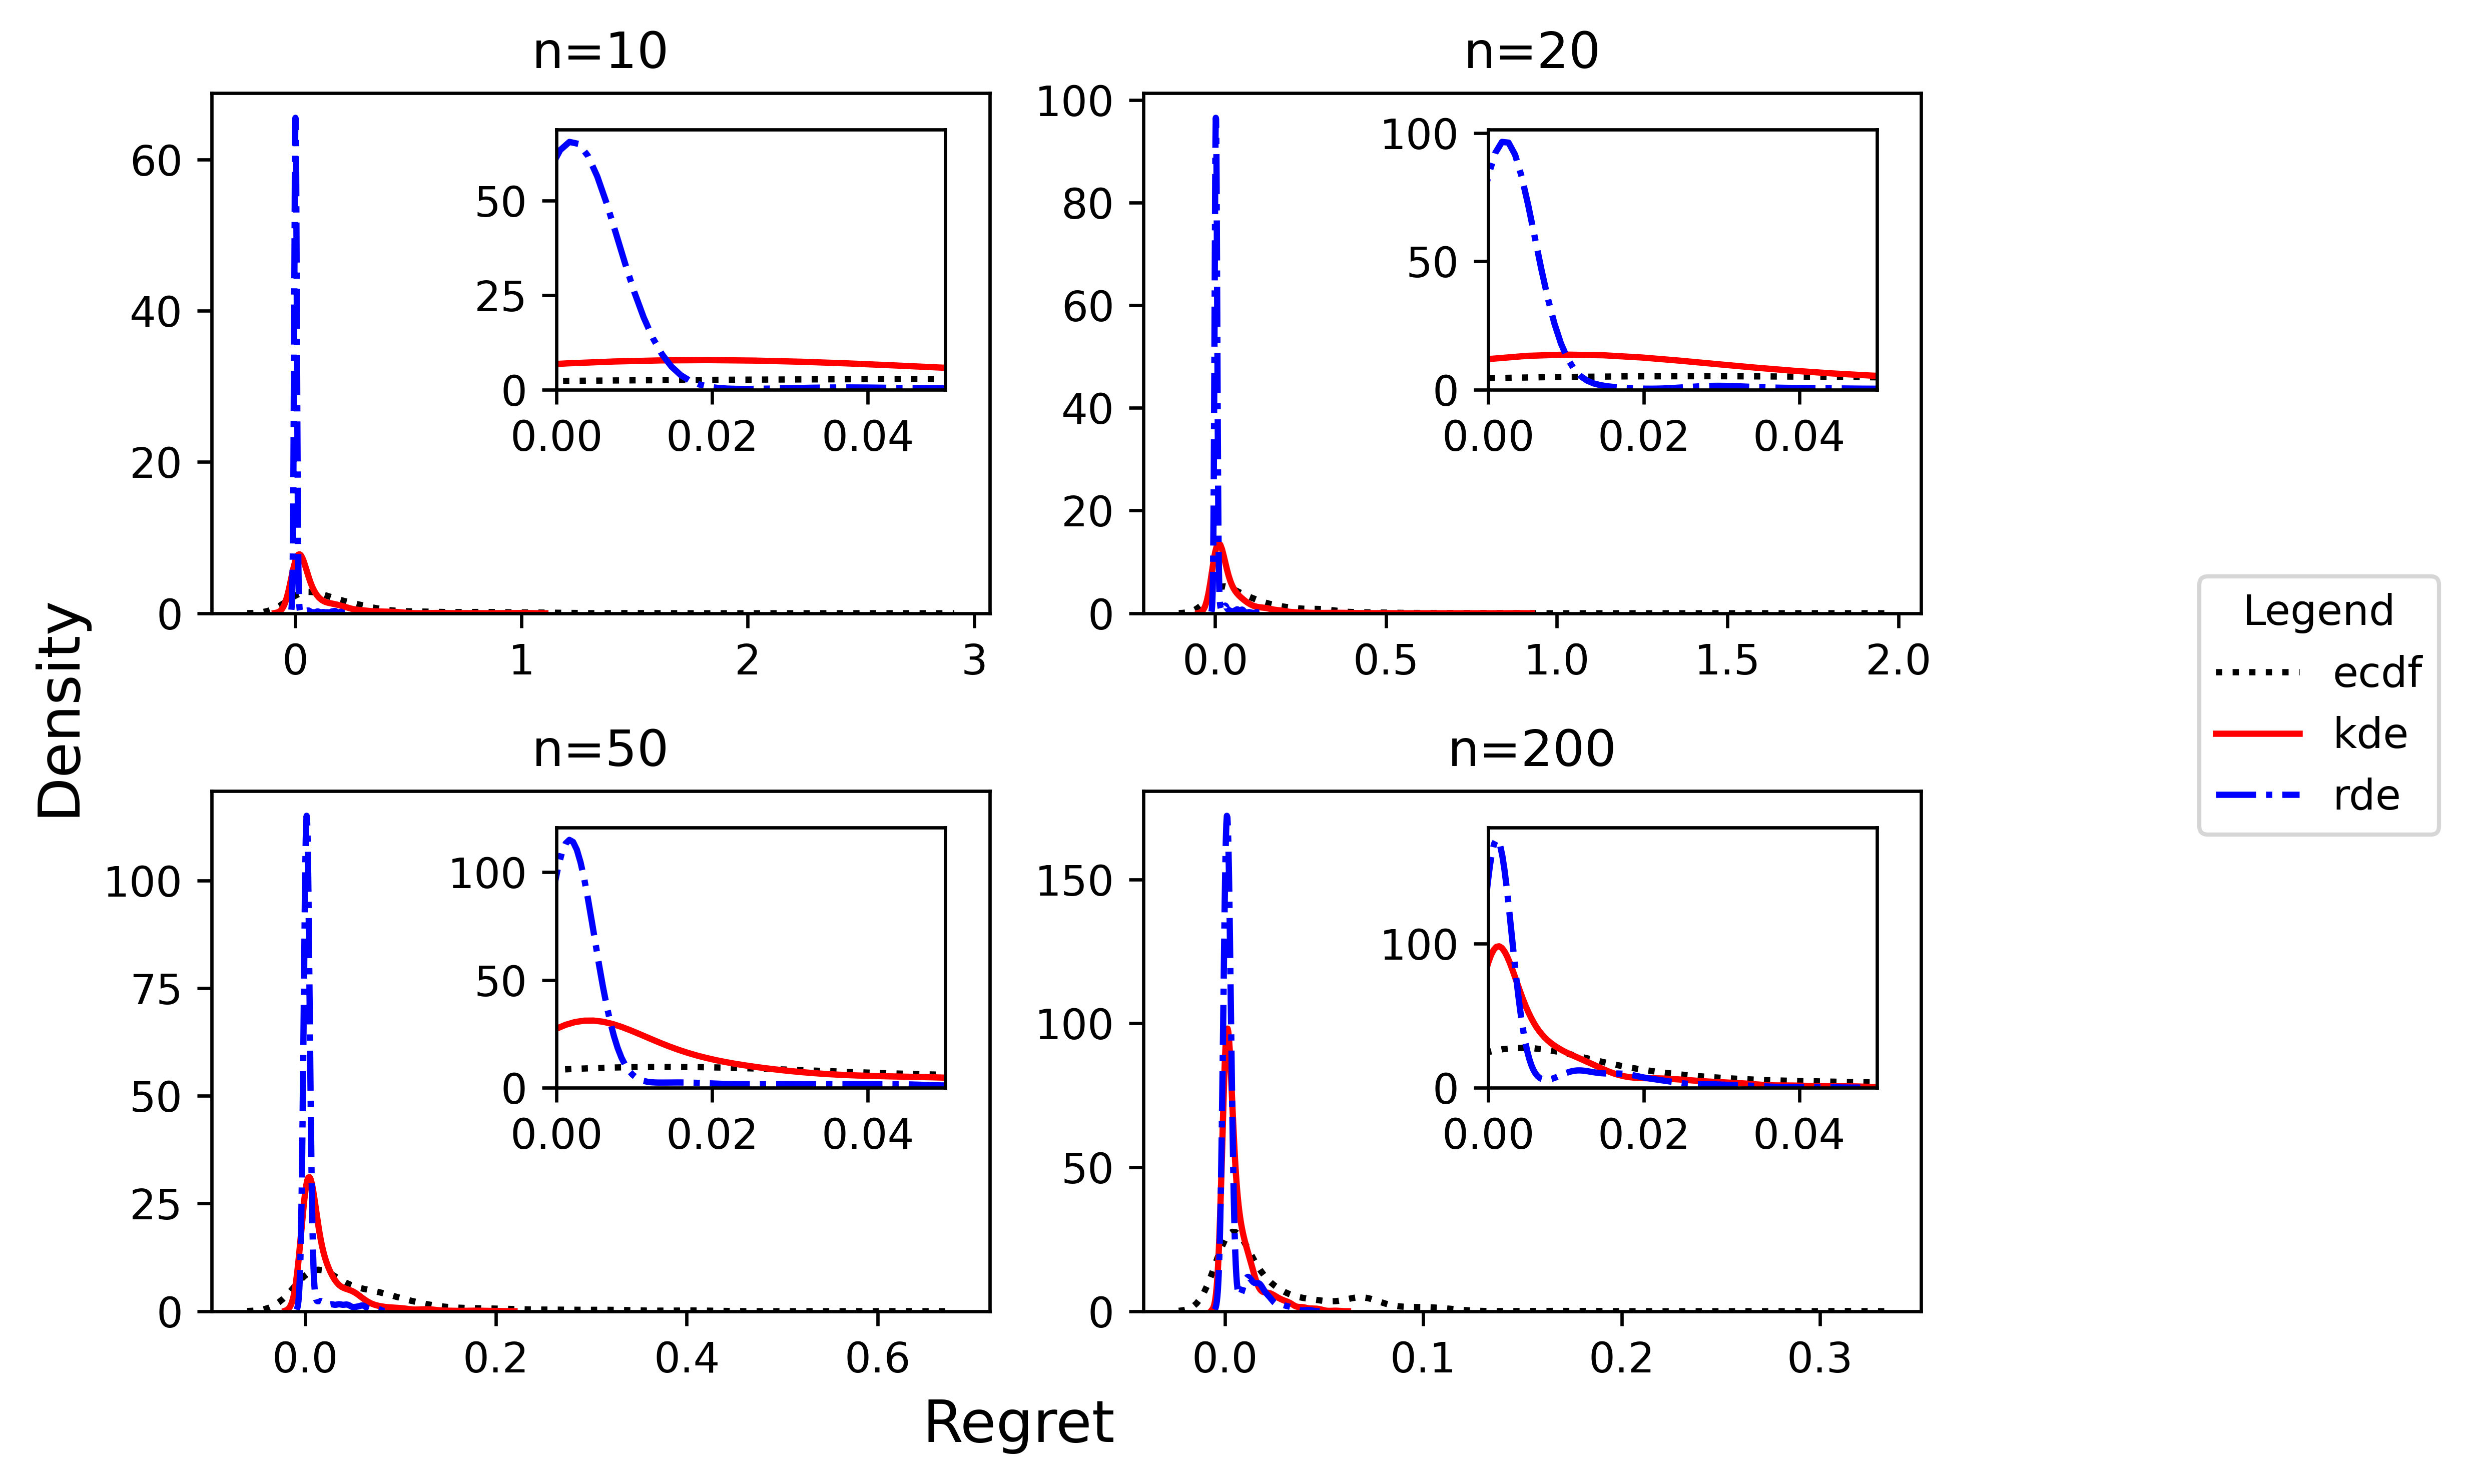

In [4]:
regrets_plot(regrets_to_plot, ns, (0, 0.05), True)

/Users/qiqi/Desktop/ADPP/_plot.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


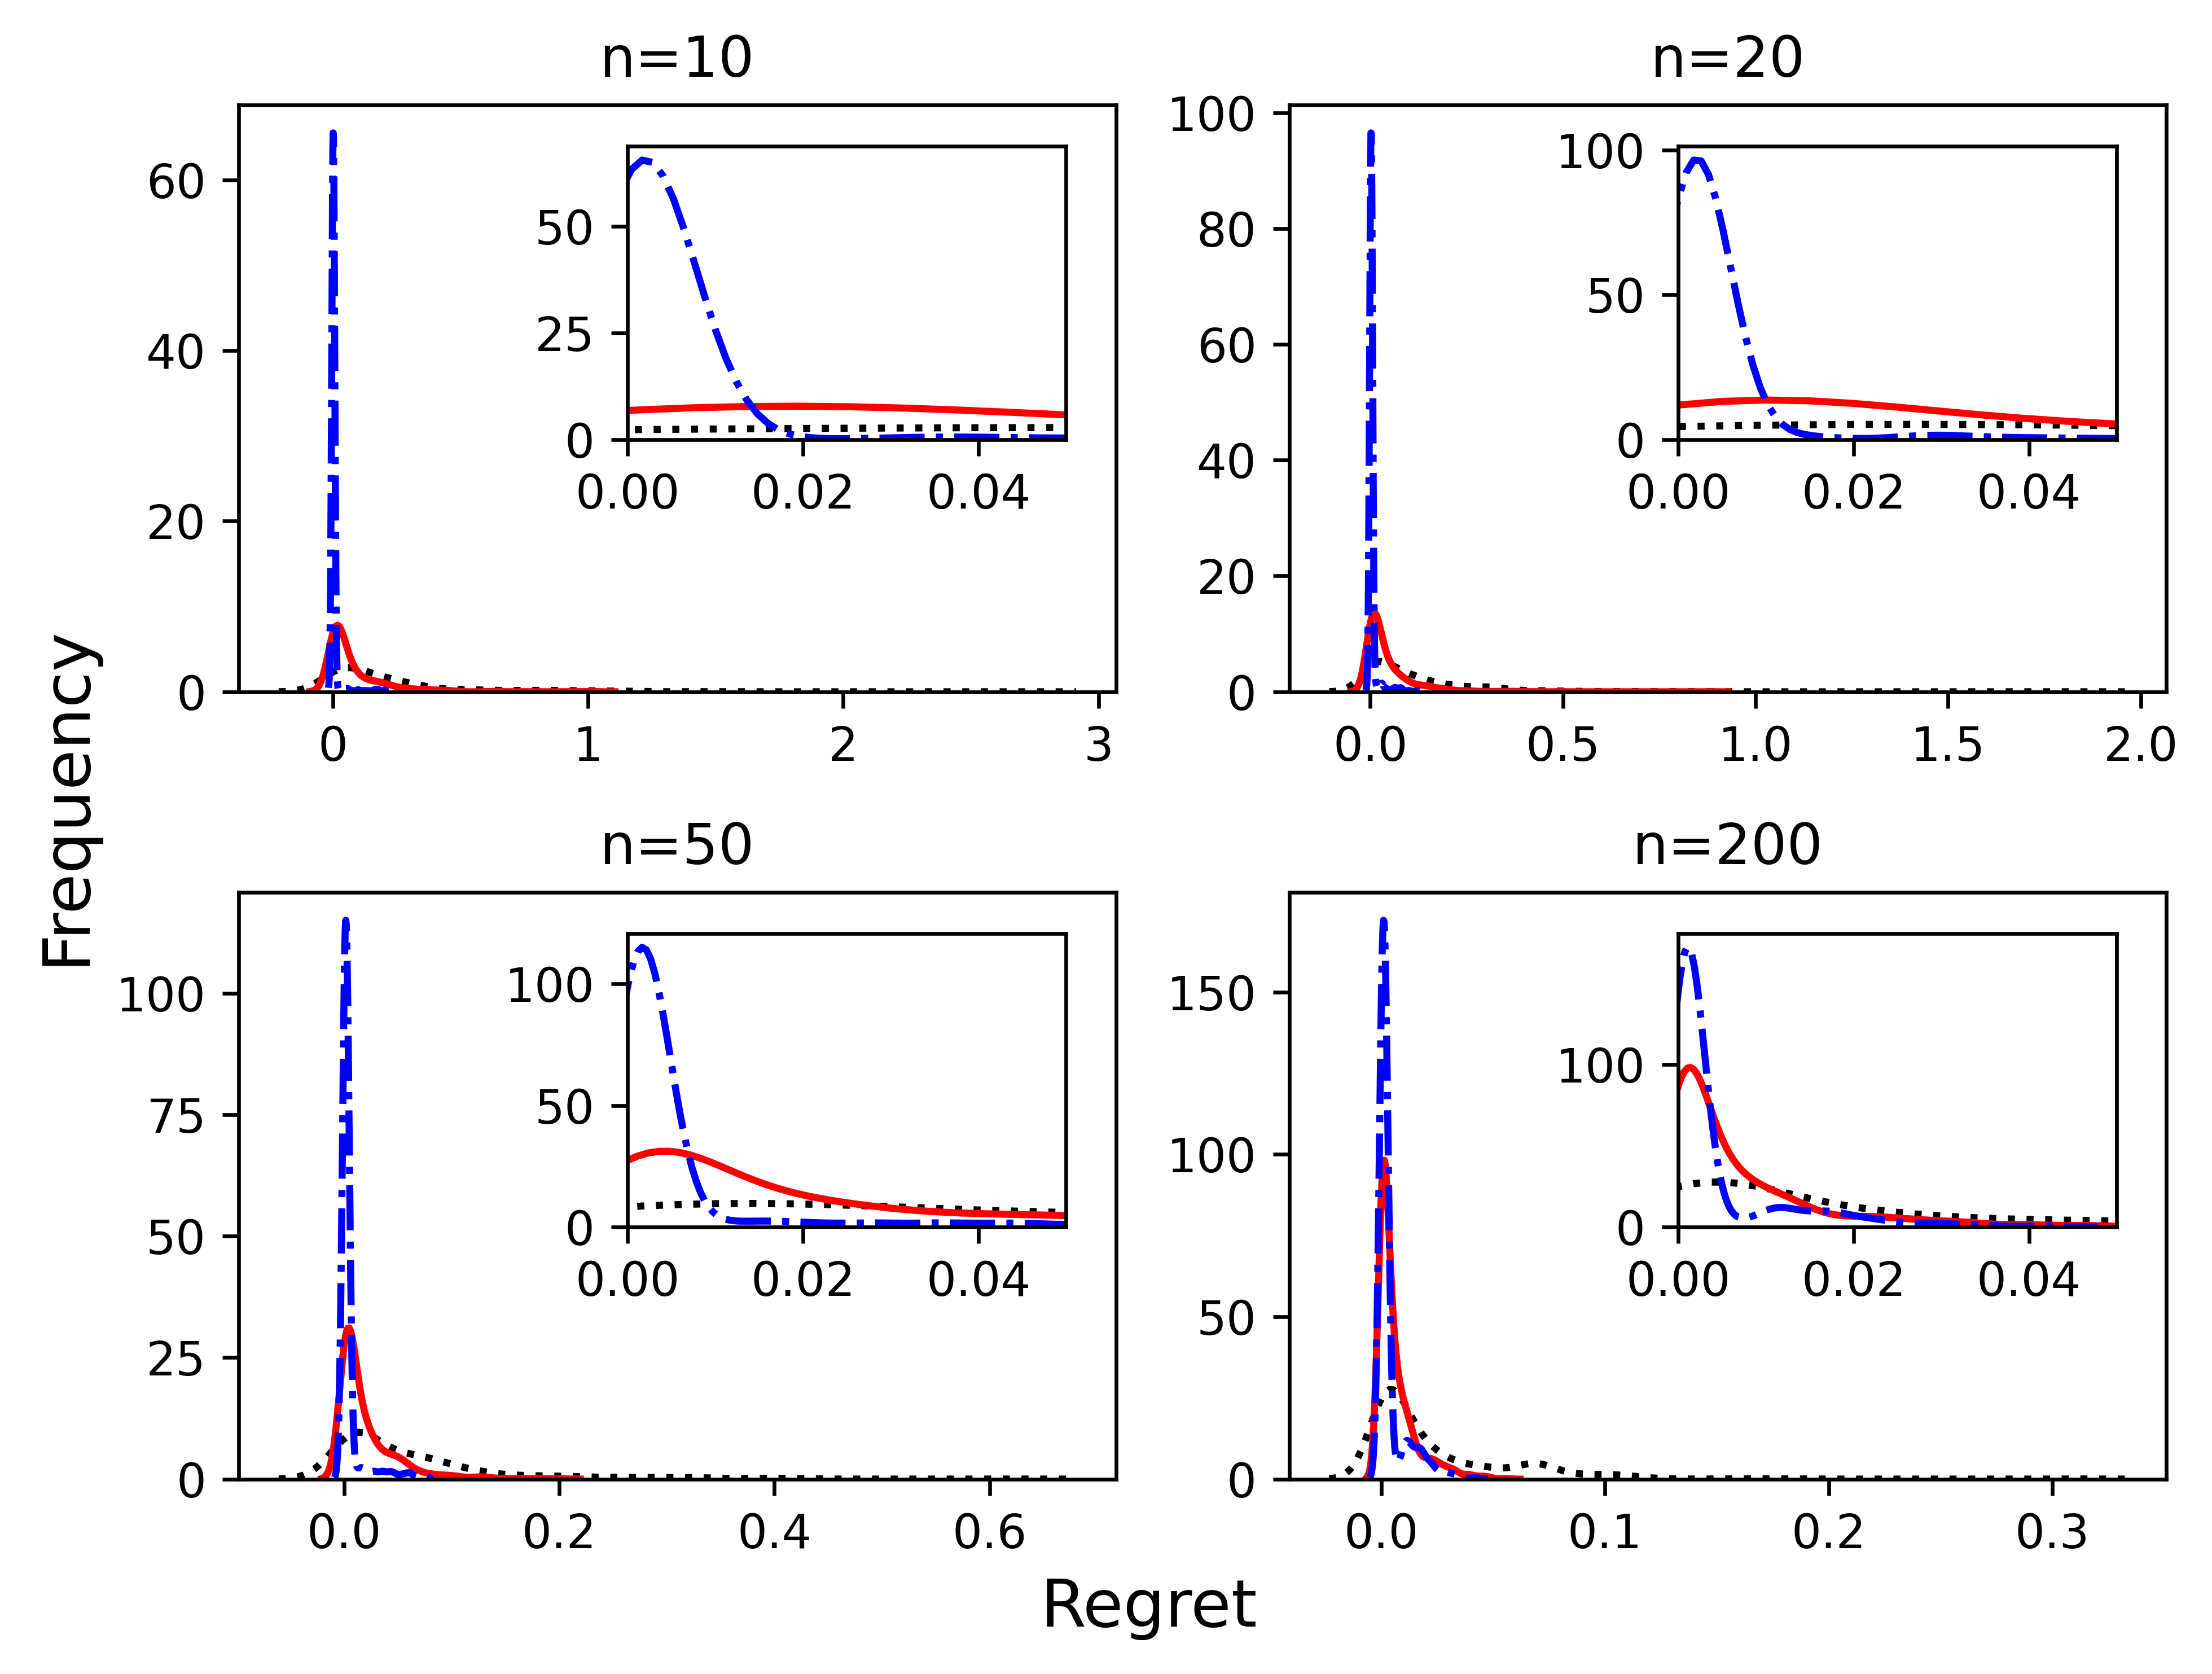

In [5]:
regrets_plot(regrets_to_plot, ns, (0, 0.05))